# 2. Data exploration

## Load utilities and programming set up

Let's start by loading the useful libraries, specifying the input data file, and preparing a utility function that will be used to save any figures later on.

In [20]:
#%pip install import-ipynb

In [21]:
import import_ipynb
from _1_DataCleaning import save_fig

In [22]:
### Read the dataset form the previous step
import pandas as pd
df = pd.read_pickle("dataset_train_step1.pickle")
df.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
1602,Attrited Customer,54,F,3,College,Single,Unknown,Blue,49,6,2,3,13184.0,0,1.166,2047,33,0.179,0.000
7791,Existing Customer,51,M,0,High School,Single,$80K - $120K,Blue,45,3,2,3,10648.0,2517,0.708,4930,89,0.978,0.236
7177,Existing Customer,45,F,4,High School,Single,$40K - $60K,Blue,29,3,2,1,4595.0,1781,0.708,3746,68,0.545,0.388
97,Existing Customer,53,M,3,Doctorate,Married,$40K - $60K,Blue,35,5,3,2,3789.0,1706,1.047,1609,42,0.680,0.450
4820,Existing Customer,48,F,2,Graduate,Married,Unknown,Blue,40,3,2,4,5104.0,736,0.679,3943,78,0.696,0.144


We will plot the column distributions using the `scatter_matrix(.)` function.
The resulting array of plots shows:
- each column distribution in the diagonal subplots
- correlations between respecive pairs of columns in the non-diagonal subplots

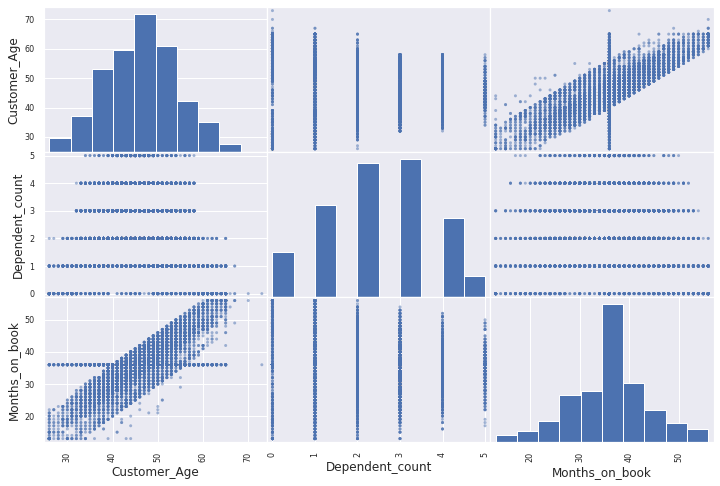

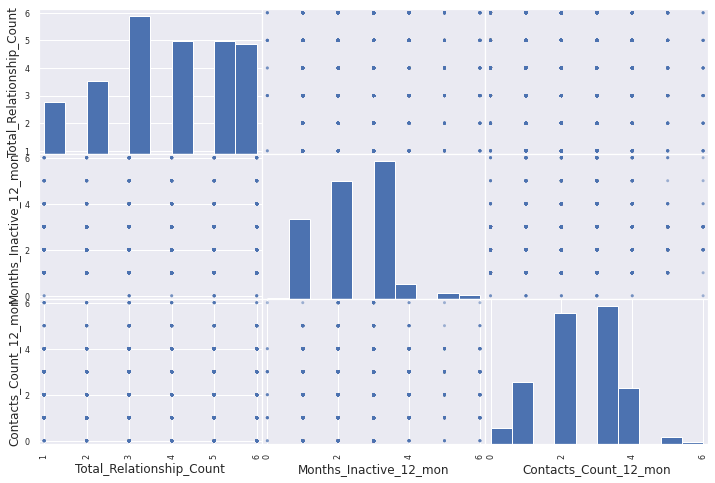

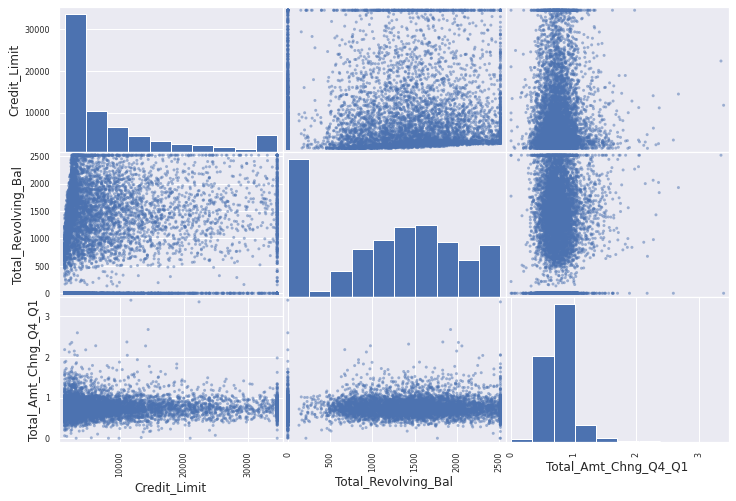

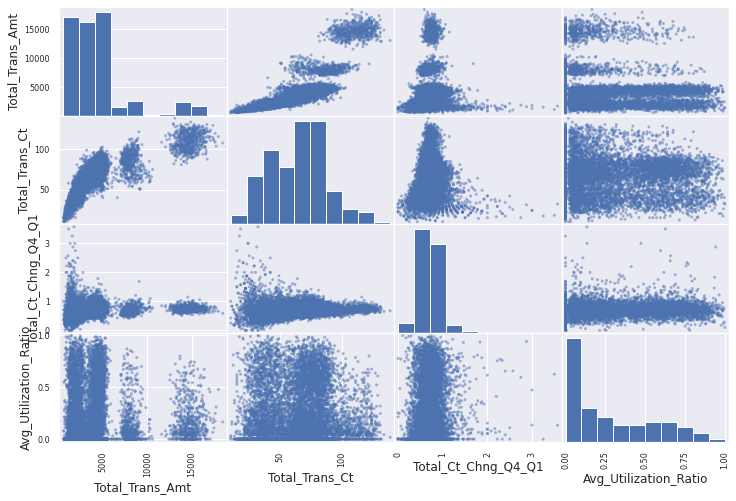

In [23]:
corr_matrix = df.corr()
from pandas.plotting import scatter_matrix
# Use a loop for more readable results
def get_cols_subset(i, n):
    cols = corr_matrix.columns
    chunk_size = len(cols) / n
    return cols[int(i*chunk_size):int((i+1)*chunk_size)]

N = 4
for i in range(N):
    cols = get_cols_subset(i,N)
    scatter_matrix(df[cols], figsize=(12,8))

One can observe various patterns, but no considerable correlations (as expected from the previous notebook), except "Months on Book" vs. "Customer Age" (correlation of 79%).
Moreover, dotted lines indicate binned nature of variables.

In [24]:
# Split feature matrix and the label vector
X = df.drop("Attrition_Flag", axis=1)
credit_labels = df['Attrition_Flag'].copy()

# Translate text to numbers and fill out unknowns

In [25]:
import numpy as np
text_cols = X.dtypes[X.dtypes == np.object]
text_cols_names = list(text_cols.index)
num_cols = X.dtypes[X.dtypes != np.object]
num_cols_names = list(num_cols.index)
print(text_cols_names)
num_cols_names

['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']


['Customer_Age',
 'Dependent_count',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio']

In [26]:
# Check what are the possible values of the text-based cells
for name in text_cols_names:
    print("Column", name)
    print(X[name].value_counts())
    print()

Column Gender
F    4262
M    3839
Name: Gender, dtype: int64

Column Education_Level
Graduate         2442
High School      1603
Unknown          1232
Uneducated       1219
College           829
Post-Graduate     404
Doctorate         372
Name: Education_Level, dtype: int64

Column Marital_Status
Married     3755
Single      3156
Unknown      599
Divorced     591
Name: Marital_Status, dtype: int64

Column Income_Category
Less than $40K    2838
$40K - $60K       1442
$80K - $120K      1244
$60K - $80K       1104
Unknown            873
$120K +            600
Name: Income_Category, dtype: int64

Column Card_Category
Blue        7541
Silver       455
Gold          91
Platinum      14
Name: Card_Category, dtype: int64



Ordinal encoders:
- all above but marital status
- Education level needs sorting

How to deal with unknowns?
- Mean: education, income
- marital status: 'unknown' must not be a separate category (onehot enc.) not to fool ML
    1. Skip this column
    2. Inspect if unknowns are Attrited Customers who are 16%, so their statistics is essential...

In [27]:
def sort_edu(val):
    "Sort education level correctly"
    order = ["Uneducated", "High School", "College", "Graduate", "Post-Graduate", "Doctorate"]
    if val in order:
        return order.index(val)
    # For unknowns return NaN to later on apply median
    return np.nan

X['Education'] = X.apply(lambda x: sort_edu(x["Education_Level"]), axis=1)
num_cols_names.append('Education')    

In [28]:
def avg_income(val):
    'Replace income ranges with range averages using regexps, eg. "$60K - $80K" -> 70'
    if val == 'Unknown':
        return np.nan
    import re
    matches = re.findall("\$[0-9]*K", val)
    matches = [float(x.replace('$','').replace('K','')) for x in matches]
    if len(matches) == 1:
        return matches[0]
    return sum(matches) / len(matches)
#avg_income("$60K - $80K")
X['Avg_Income'] = X.apply(lambda x: avg_income(x['Income_Category']), axis=1)
X['Avg_Income']
# Add this column to the numerical ones and remove from the categorical ones
num_cols_names.append('Avg_Income')

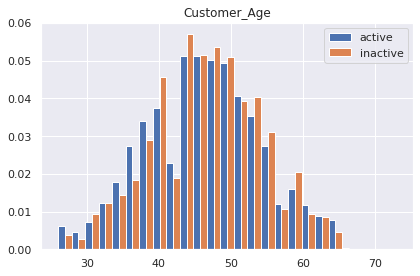

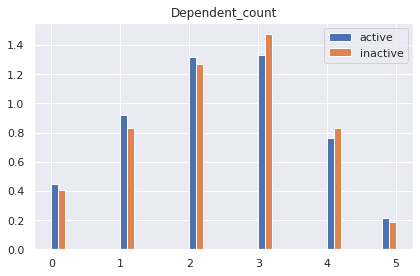

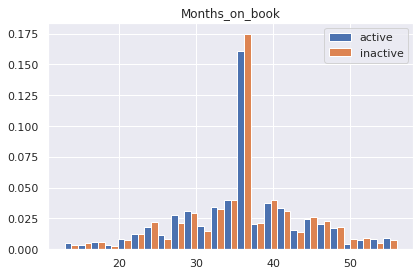

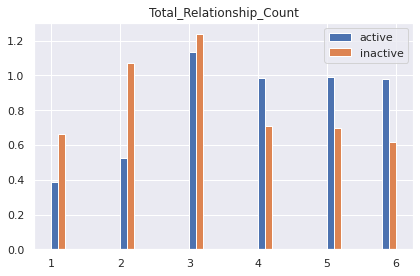

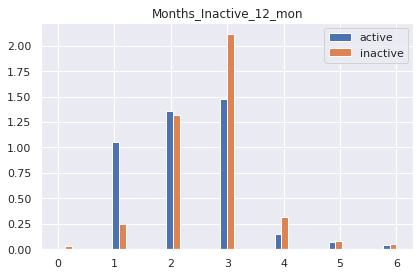

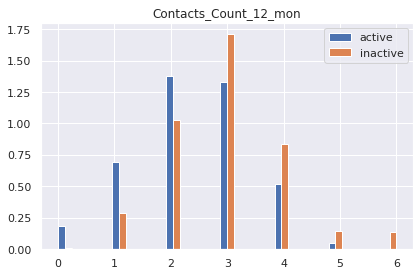

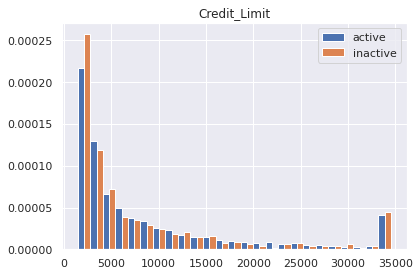

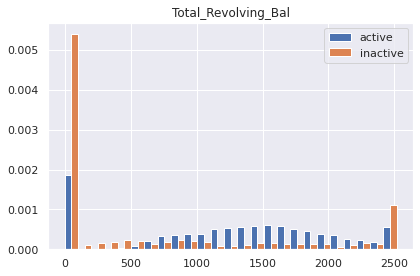

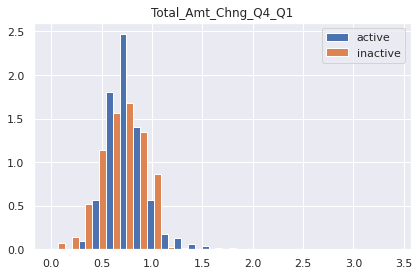

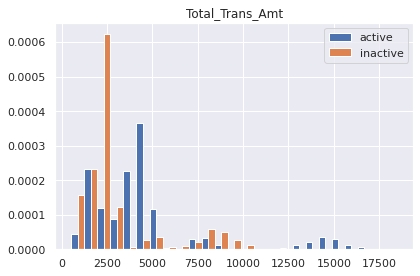

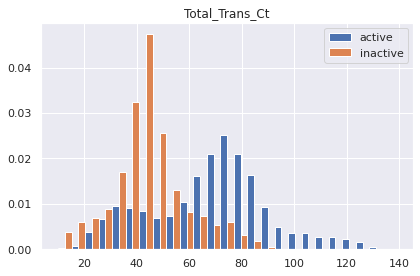

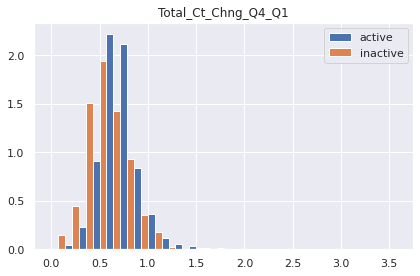

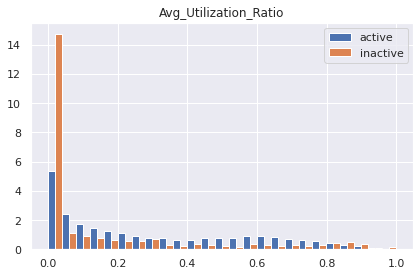

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
# Apply the default theme
sns.set_theme(font_scale=1)
colours = ('blue', 'red')

# Split dataframe into two groups of customers (for plotting only)
# Use the original train df, not the feauture vector
X_active = df.loc[df['Attrition_Flag']=="Existing Customer"]
X_inactive = df.loc[df['Attrition_Flag']=="Attrited Customer"]
for col in df.columns:
    if df[col].dtypes == np.object:
        continue
    if col=='Education' or col=='Avg_Income':
        continue # hack because df has no access to label :-()
    #f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    #axes = (ax1, ax2)
    #for i, df_i in enumerate((df_active, df_inactive)):
    fig = plt.figure() 
    ax = fig.add_subplot(111)
    ax.hist([X_active[col], X_inactive[col]], label=("active", "inactive"), bins=25, density=True,rwidth=1.0)#, range=[0, 25])
    ax.set_title(col)
    ax.legend()
        #df_i.hist(column=col, bins=30, figsize=(8,3), color=colours[i], ax=axes[i])#, layout=(10,2))
        #save_fig("attribute_histogram_plots")
    plt.tight_layout()
    plt.show()

Features that distinguish the two categories of customers:
['Total_Relationship_Count', 'Months_inactive_12_mon', 'Contacts_Count_12_mon', 'Total_Revolving_Bal',
'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1',
'Avg_Utilization_Ratio']

Not so sure, but taken:
['Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Ct_Chng_Q4_Q1']

Credit limit has a peak at the highest bin. This may be a max credit limit offerred by the bank.

In [20]:
from sklearn.preprocessing import OrdinalEncoder
# ordinal_encoder = OrdinalEncoder()
# attrition_flag_encoded = ordinal_encoder.fit_transform(df[["Card_Category"]])
# attrition_flag_encoded[:10]
# #ordinal_encoder.categories_

ordered_cols_names = "Gender Card_Category".split()
#onehot_cols_names = "Marital_Status".split()

# from sklearn.preprocessing import OneHotEncoder
# cat_encoder = OneHotEncoder()
# marital_1hot = cat_encoder.fit_transform(df[['Marital_Status']])
# marital_1hot.toarray()

The only NaNs to be fixed are the ones in num_cols_names, specifically in education and income.
Let's assign median to these.

In [21]:
from sklearn.impute import SimpleImputer

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# All the numeric data preprocessing:
# - usually NaNs (e.g. median)
# - adding extra attributes (e.g. functions of the original ones)
# - scaling: standardisation or normalisation
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

from sklearn.compose import ColumnTransformer

powerful_features = ['Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Total_Revolving_Bal',
'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1',
'Avg_Utilization_Ratio']
for name in num_cols_names:
    if name not in powerful_features:
        print('Not good:', name)
        num_cols_names.remove(name)

# Final list of features to be used (not sure about the ordered ones; not checked their discriminating power)
print("Final list of features to be used:", num_cols_names + ordered_cols_names)

# ColumnTransformer executes the pipelines on specified lists of column names
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_cols_names),
    ('ordered', OrdinalEncoder(), ordered_cols_names)
    #('cat', OneHotEncoder(), text_cols_names),
])

credit_prepared = full_pipeline.fit_transform(df)
from sklearn.preprocessing import LabelEncoder
credit_labels_prepared = LabelEncoder().fit_transform(credit_labels)
print(credit_labels_prepared)
# So far all categorical columns were treated with OneHotEncoder, which is not ideal and later I can specify new
# categories for those cat. columns that should be treated otherwise. Nice setup!

Not good: CLIENTNUM
Not good: Dependent_count
Not good: Credit_Limit
Not good: Education
Final list of features to be used: ['Customer_Age', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Avg_Income', 'Gender', 'Card_Category']
[0 1 1 ... 1 1 1]


In [23]:
credit_prepared

array([[ 0.96087863,  1.64154853,  1.40868897, ..., -0.45995856,
         0.        ,  0.        ],
       [ 0.58518711,  1.13884339, -0.5306623 , ...,  1.44306713,
         1.        ,  0.        ],
       [-0.16619592, -0.87197715, -0.5306623 , ..., -0.45995856,
         0.        ,  0.        ],
       ...,
       [ 0.45995661,  0.00775684,  1.40868897, ..., -0.8405637 ,
         0.        ,  0.        ],
       [-0.41665693,  0.00775684, -0.5306623 , ...,  0.30125171,
         1.        ,  0.        ],
       [ 0.96087863,  0.00775684,  0.76223855, ...,  0.30125171,
         1.        ,  0.        ]])